In [7]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import hydroAI.SMAP as hSMAP
import hydroAI.Plot as Plot
import hydroAI.Data as Data
importlib.reload(hSMAP);
importlib.reload(Plot);
importlib.reload(Data);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

## 1. Import and Save SMAPL3 or SMAPL3_E SM data

In [2]:
# Usage example
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
#mission_product = 'SPL3SMP_E.005'
year = 2022
directory = os.path.join(cpuserver_data_FP, mission, mission_product)
file_list, data_doy = hSMAP.extract_filelist_doy(directory, year) 
longitude, latitude = hSMAP.get_e2grid(cpuserver_data_FP, mission_product)

In [ ]:
# Usage example - create_array_from_h5
group_name = 'Soil_Moisture_Retrieval_Data_AM'

variable_name = 'soil_moisture'
SMAP_SM_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'retrieval_qual_flag'
SMAP_QF_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_3'
SMAP_tb3_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_4'
SMAP_tb4_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'soil_moisture_error' 
SMAP_SM_error_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'vegetation_water_content' 
SMAP_VWC_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)

In [ ]:
# Usage example - create_netcdf_file
# SMAPL3 AM
nc_file_name = os.path.join(nc_save_dir,mission_product+'_'+str(year)+'_am_ex.nc')

hSMAP.create_netcdf_file(
    nc_file=nc_file_name, 
    latitude=latitude, 
    longitude=longitude, 
    SMAP_SM_AM=SMAP_SM_AM,
    SMAP_QF_AM=SMAP_QF_AM,
    SMAP_tb3_flag_AM=SMAP_tb3_flag_AM,
    SMAP_tb4_flag_AM=SMAP_tb4_flag_AM,
    SMAP_SM_error_AM=SMAP_SM_error_AM,
    SMAP_VWC_AM=SMAP_VWC_AM
)

In [ ]:
# Loop through everything from 2015 to 2023 for AM/PM data
mission = 'SMAP'
mission_product = 'SPL3SMP.008'

# Ensure the directory for saving NetCDF files exists
os.makedirs(os.path.join(cpuserver_data_FP, nc_save_dir), exist_ok=True)

# Variables to process
variables = [
    'soil_moisture',
    'retrieval_qual_flag',
    'tb_qual_flag_3',
    'tb_qual_flag_4',
    'soil_moisture_error',
    'vegetation_water_content'
]

for year in range(2015, 2024):
    directory = os.path.join(cpuserver_data_FP, mission, mission_product)
    file_list, data_doy = hSMAP.extract_filelist_doy(directory, year)
    longitude, latitude = hSMAP.get_e2grid(cpuserver_data_FP, mission_product)

    # Loop for AM and PM
    for suffix in ['AM', 'PM']:
        group_name = f'Soil_Moisture_Retrieval_Data_{suffix}'

        # Collect data for each variable
        data_vars = {}
        for var in variables:
            variable_name = f"{var}_{suffix.lower()}" if suffix == 'PM' else var
            data, _, _ = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
            data_vars[variable_name] = data
        
        # Save to NetCDF file
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{suffix.lower()}.nc')
        hSMAP.create_netcdf_file(nc_file=nc_file_name, latitude=latitude, longitude=longitude, **data_vars)
        print(f"Data for {year} {suffix} saved to {nc_file_name}")

In [ ]:
# Display the map with plot_global_map
nanmean_SMAP_SM_AM = np.nanmean(SMAP_SM_AM, axis=2)
target = nanmean_SMAP_SM_AM
Plot.plot_global_map(longitude, latitude, target, 'SMAP SM', np.nanmin(target), np.nanmax(target), 'jet_r')
 
# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(longitude, latitude, target, 'SMAP SM', np.nanmin(target), np.nanmax(target), 'jet_r', bound)

# 2. Resample SMAP data

### 2.1. Load the domain lat/lon

In [3]:
# Resample SMAP data into GLDAS NOAH 0.25 x 0.25 grid
domain_nc_file = cpuserver_data_FP+'/grids/GLDAS_NOAH_025.nc'
nc_data = netCDF4.Dataset(domain_nc_file)
domain_lon = np.flipud(nc_data.variables['lon'][:]).data
domain_lat = np.flipud(nc_data.variables['lat'][:]).data
nc_data.close()

In [4]:
# Resample SMAP data into EASE2 grid
#domain_lon, domain_lat = hSMAP.get_e2grid(cpuserver_data_FP, mission_product)

In [5]:
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
target_projection = 'Noah_025'

### 4.2. Resample SMAP data

In [6]:
for year in range(2015, 2024):
    path_list = ['am','pm']
    
    for path in path_list:
        # resample SMAP into the doamin size
        nc_file  = nc_save_dir+'/'+mission_product+'_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)

        if path == 'pm':
            SMAP_SM  = nc_data.variables['soil_moisture_'+path][:].data
            SMAP_QF  = nc_data.variables['retrieval_qual_flag_'+path][:].data.astype(int)
        else:
            SMAP_SM  = nc_data.variables['soil_moisture'][:].data
            SMAP_QF  = nc_data.variables['retrieval_qual_flag'][:].data.astype(int)
            
        SMAP_lat = nc_data.variables['latitude'][:].data
        SMAP_lon = nc_data.variables['longitude'][:].data
        nc_data.close()

        # Define the mask for "Retrieval_recommended"
        retrieval_recommended_mask = 1
        
        # Apply the mask to the retrieval_qual_flag to get a boolean array where True indicates "Retrieval_recommended"
        retrieval_recommended = (SMAP_QF & retrieval_recommended_mask) != 0

        # Use broadcasting to apply the mask across the last dimension of the data_array
        SMAP_SM_QC = np.where(retrieval_recommended, SMAP_SM, np.nan)
        #SMAP_SM_QC = SMAP_SM
        Resampled_SMAP_SM = Data.Resampling_forloop(domain_lat, domain_lon, SMAP_lat, SMAP_lon, SMAP_SM)
        Resampled_SMAP_SM_QC = Data.Resampling_forloop(domain_lat, domain_lon, SMAP_lat, SMAP_lon, SMAP_SM_QC)
        
        # Save to NetCDF file
        data_vars = {}
        data_vars['Resampled_SMAP_SM'] = Resampled_SMAP_SM
        data_vars['Resampled_SMAP_SM_QC'] = Resampled_SMAP_SM_QC
        
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
        hSMAP.create_netcdf_file(nc_file=nc_file_name, latitude=domain_lat, longitude=domain_lon, **data_vars)
        print(f"Data for {year} {path} saved to {nc_file_name}")

100%|████████████████████████████████████████| 366/366 [00:02<00:00, 145.13it/s]


NetCDF file /Users/hyunglokkim/cpuserver_data/extracted_nc/SPL3SMP.008_2022_pm_R_Noah_025.nc created successfully.
Data for 2022 pm saved to /Users/hyunglokkim/cpuserver_data/extracted_nc/SPL3SMP.008_2022_pm_R_Noah_025.nc


In [ ]:
# Check the resampled data
doy = 121
r_smap = Resampled_SMAP_SM_QC[:,:,doy]
Plot.plot_global_map(domain_lon, domain_lat, r_smap, 're_SMAP_SM', 0, 0.5, 'jet_r')
smap = SMAP_SM[:,:,doy]
Plot.plot_global_map(SMAP_lon, SMAP_lat, smap, 'or_SMAP_SM', 0, 0.5, 'jet_r')

In [30]:
# Compare the SMAPL3_E- bnad SMAPL3-based Resampling Results
year = 2022
path = 'am'
target_projection = 'Noah_025' 

mission_product = 'SPL3SMP_E.005'
nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
nc_data = netCDF4.Dataset(nc_file_name)
SMAPL3E_R_SM = nc_data.variables['Resampled_SMAP_SM_QC'][:,:, 150].data

mission_product = 'SPL3SMP.008'
nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{path}_R_{target_projection}.nc')
nc_data = netCDF4.Dataset(nc_file_name)
SMAPL3_R_SM = nc_data.variables['Resampled_SMAP_SM_QC'][:,:, 150].data
domain_lon = nc_data.variables['longitude'][:].data
domain_lat = nc_data.variables['latitude'][:].data

mission_product = 'SPL3SMP.008'
nc_file_name  = nc_save_dir+'/'+mission_product+'_'+str(year)+'_'+path+'.nc'
nc_data = netCDF4.Dataset(nc_file_name)
SMAPL3_or_SM = nc_data.variables['soil_moisture'][:,:, 150].data
SMAP_lon = nc_data.variables['longitude'][:].data
SMAP_lat = nc_data.variables['latitude'][:].data

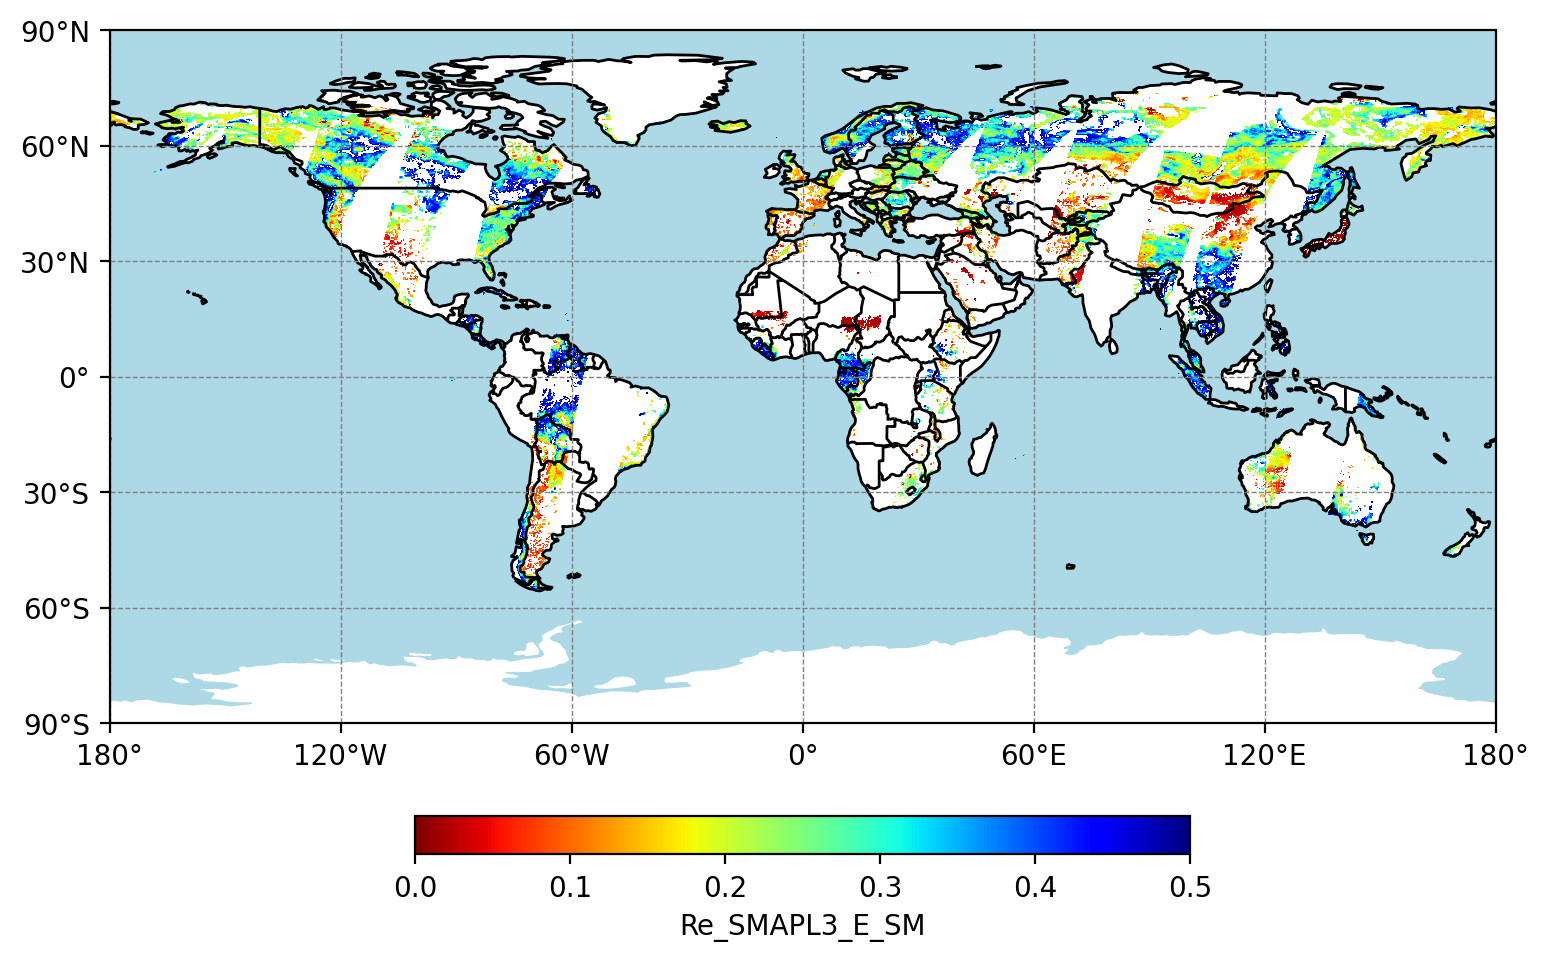

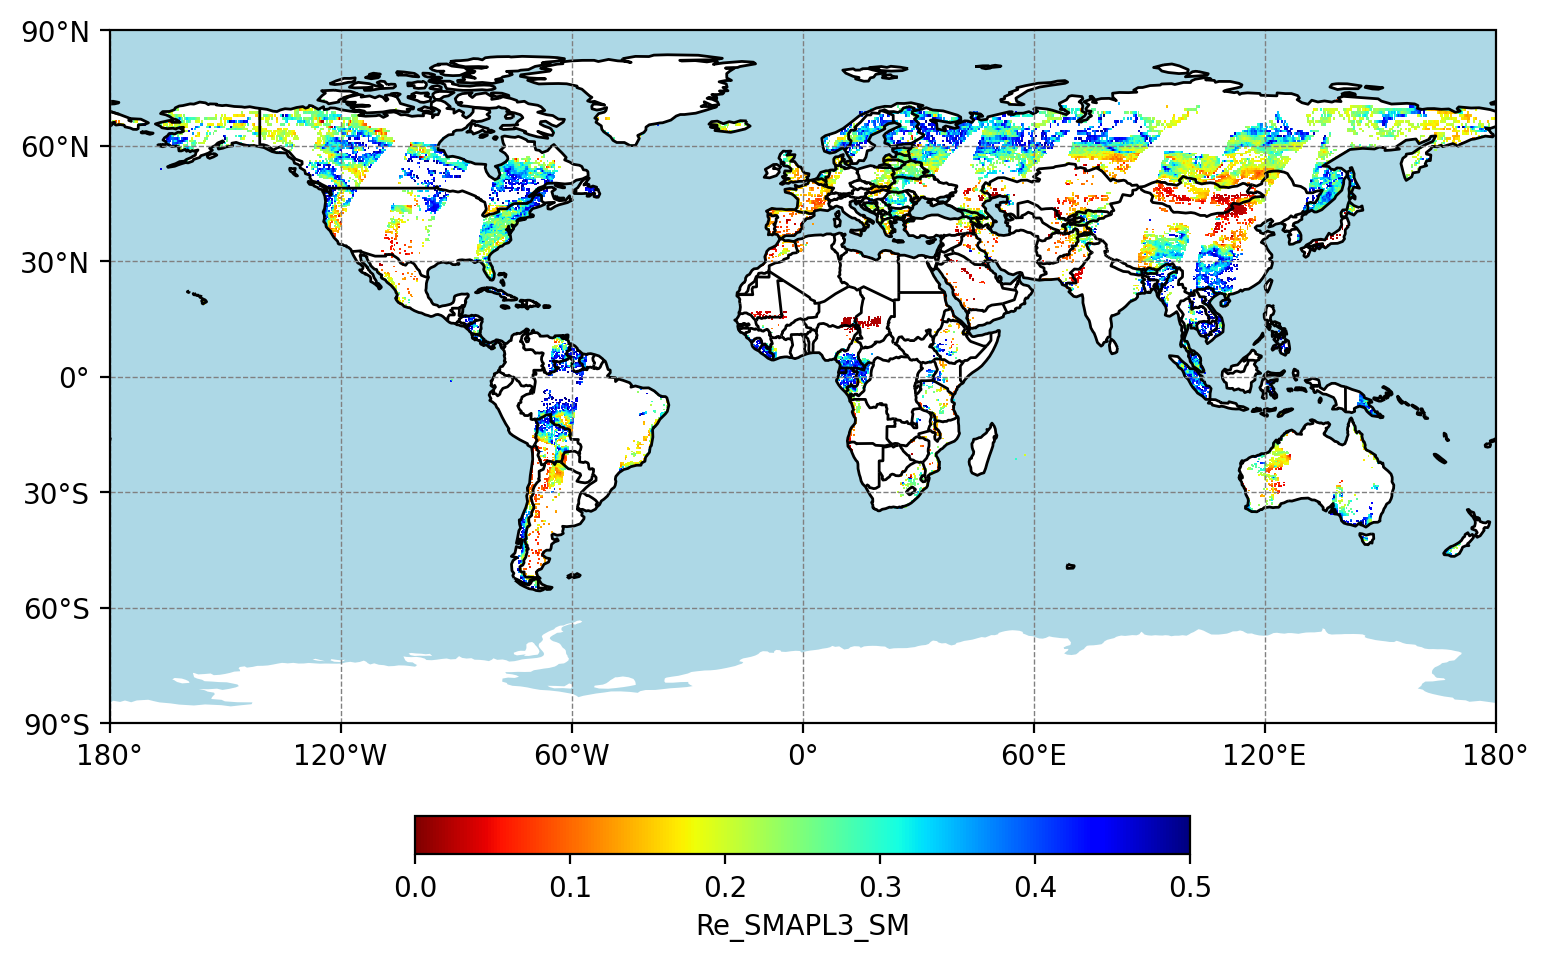

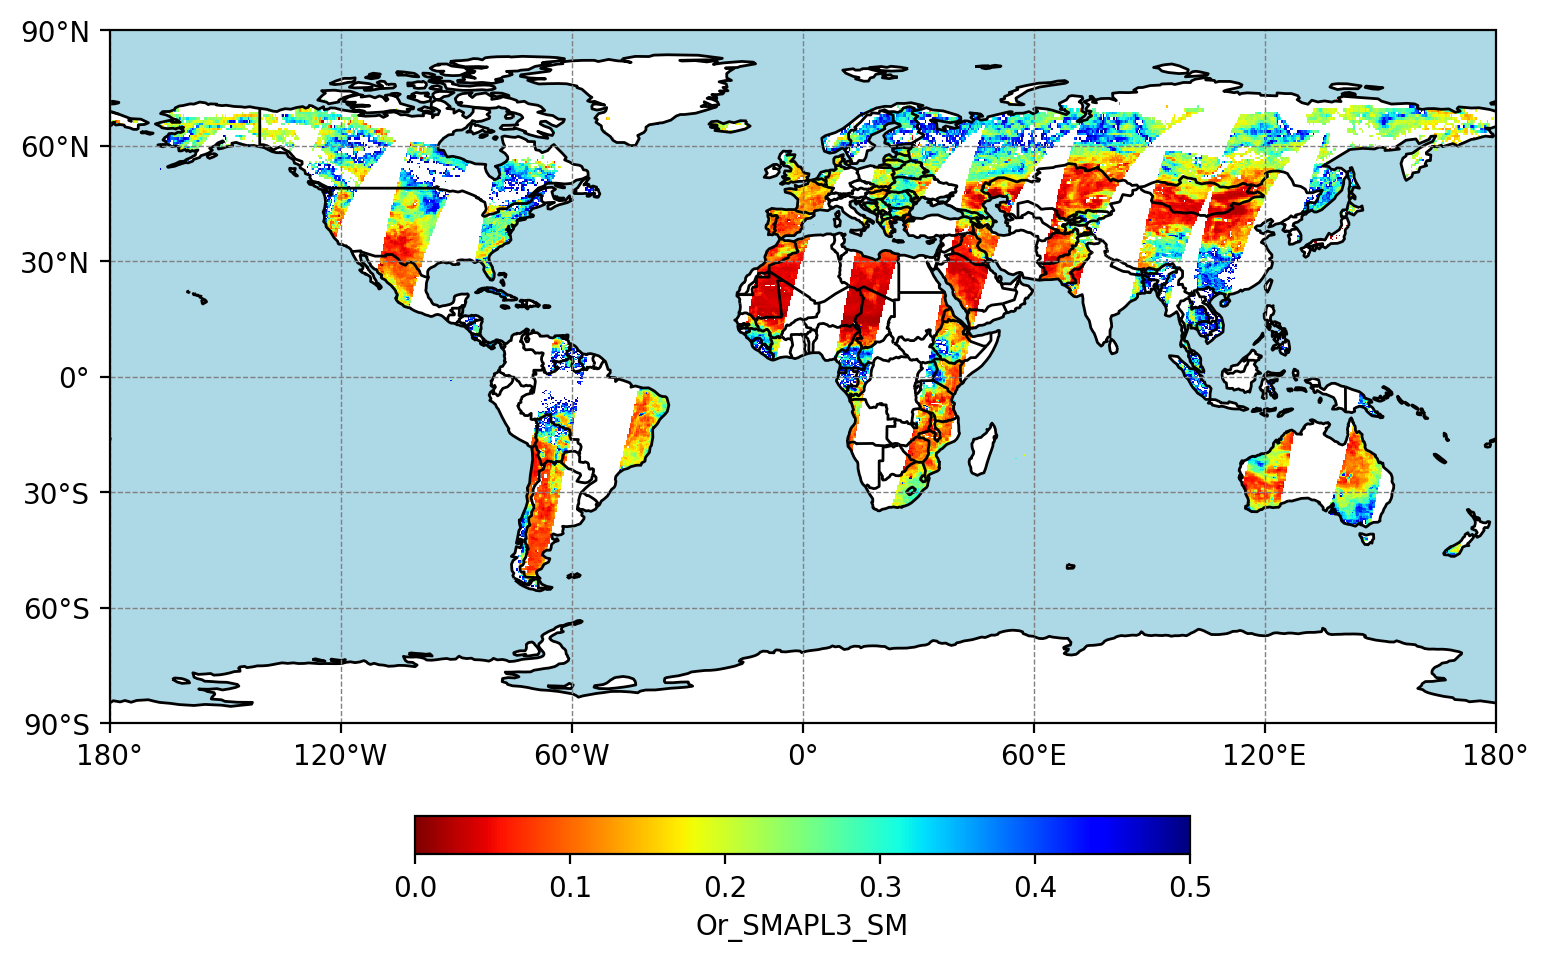

In [31]:
Plot.plot_global_map(domain_lon, domain_lat, SMAPL3E_R_SM, 'Re_SMAPL3_E_SM', 0, 0.5, 'jet_r')
Plot.plot_global_map(domain_lon, domain_lat, SMAPL3_R_SM, 'Re_SMAPL3_SM', 0, 0.5, 'jet_r')
Plot.plot_global_map(SMAP_lon, SMAP_lat, SMAPL3_or_SM, 'Or_SMAPL3_SM', 0, 0.5, 'jet_r')